In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score


from scipy.special import comb

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

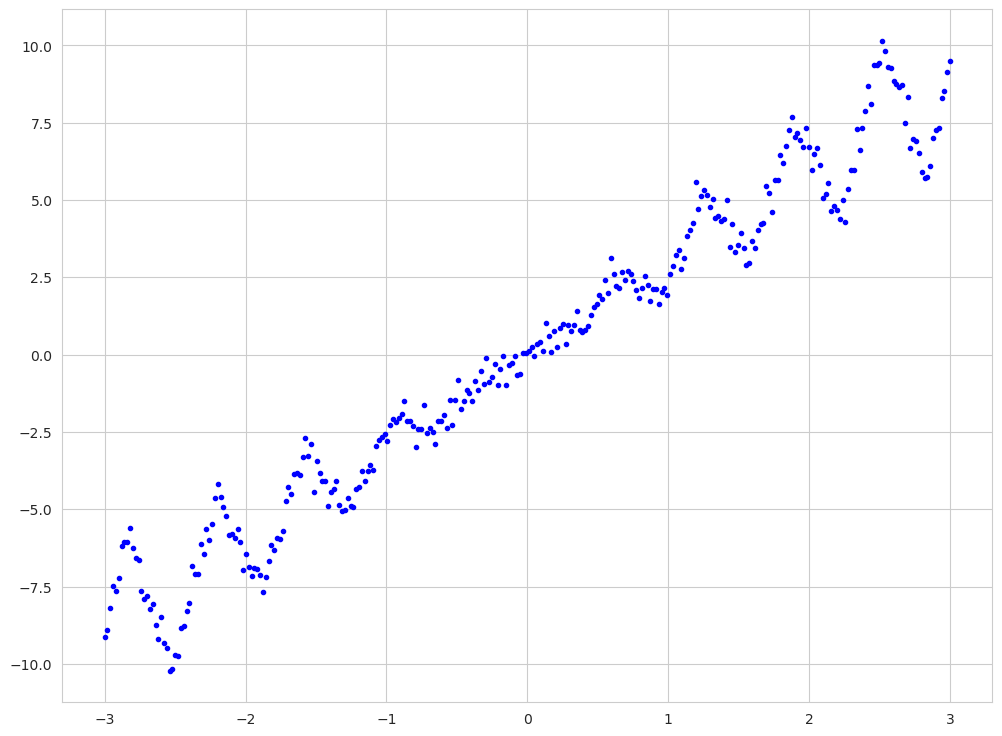

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [27]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, max_depth, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    y_pred1 = tree_reg.predict(X)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.text(1, 0, [f'R2 score {max_depth} model:', r2_score(y, y_pred1)], fontsize=10, ha='right', va='bottom', transform=plt.gca().transAxes)

    #plt.legend([f'R2 score of max_depth = {max_depth} model:', r2_score(y, y_pred)], loc='lower right')
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

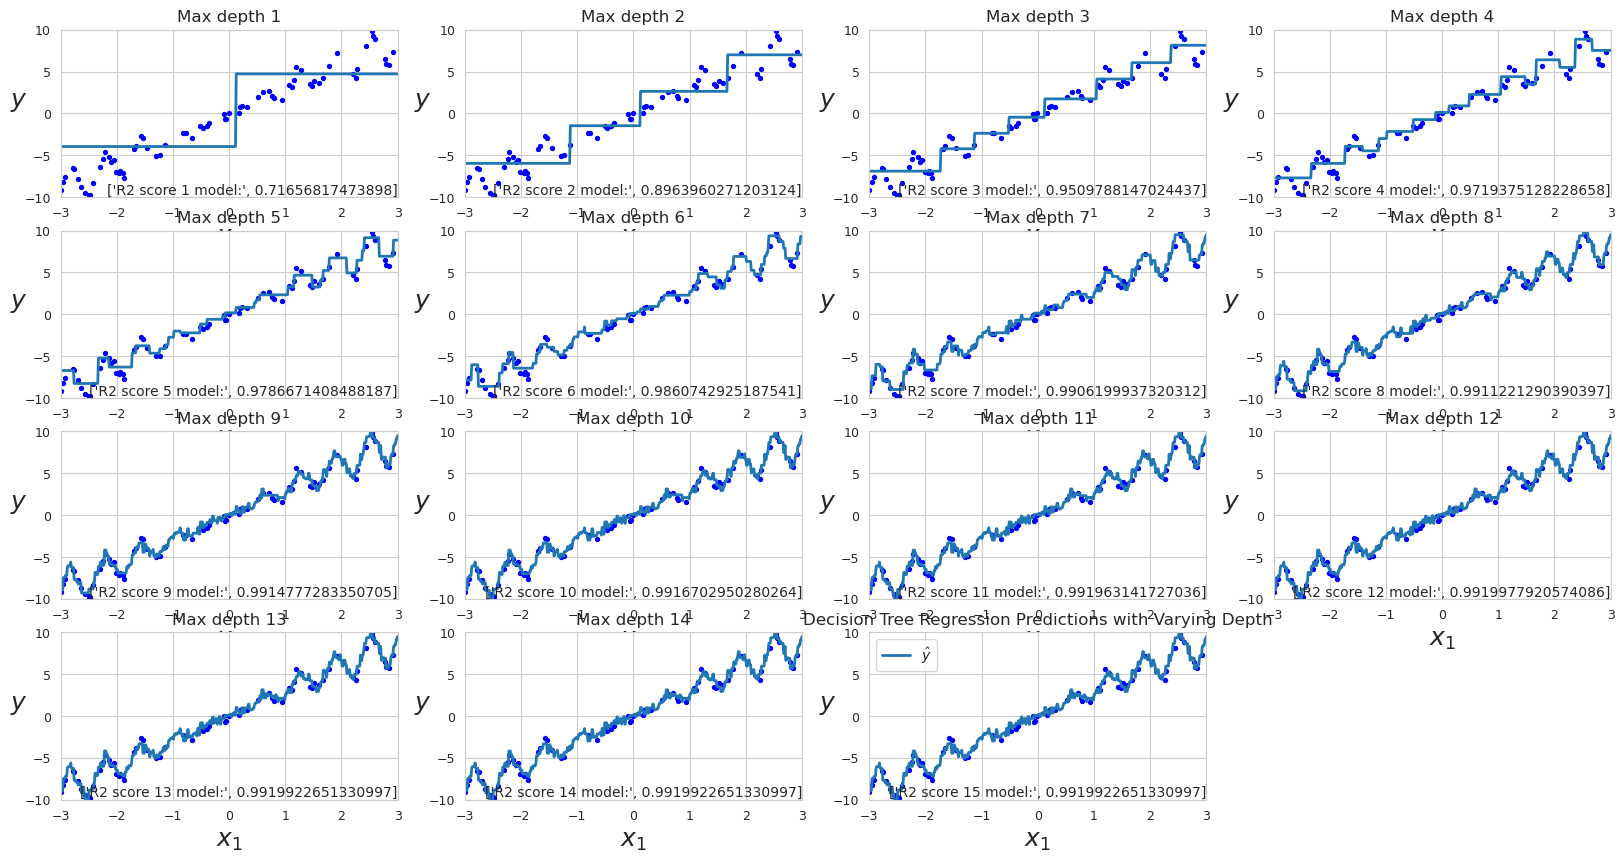

In [28]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
plt.figure(figsize=(20, 10))
for max_depth in range(1, 16):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=SEED)
    tree_reg.fit(X_train, y_train)
    plt.subplot(4, 4, max_depth)
    plot_regression_predictions(tree_reg, X_test, y_test, max_depth)
    plt.scatter(X_test, y_test, color='b', linewidth=1, s=8)
    plt.tick_params(axis='both', which='major', labelsize=9)
    
    plt.title(f'Max depth {max_depth}')
    

#plt.scatter(X, y, color='blue', alpha=0.5, label='Training data')
plt.legend()
plt.title('Decision Tree Regression Predictions with Varying Depth')
plt.show()

Глубина 4 лучше всего подходит для этой задачи, чем выше глубина, тем выше варианс, чем ниже она, тем выше смещение. Я думаю, что при глубине 4 баланс плюс минус достигнут (визуальная оценка). Оценинка варианс с помощью r2-score помогла заметить, что у модели с максимальной глубиной в 13 r2 ниже, чем у модели 12. Значит, variance после определенной глубины начинает повышаться.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [30]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
def probability_correct_classification(p):
    mu = sum(comb(101, i) * p**i * (1-p)**(101-i) for i in range(51, 102))
    return mu

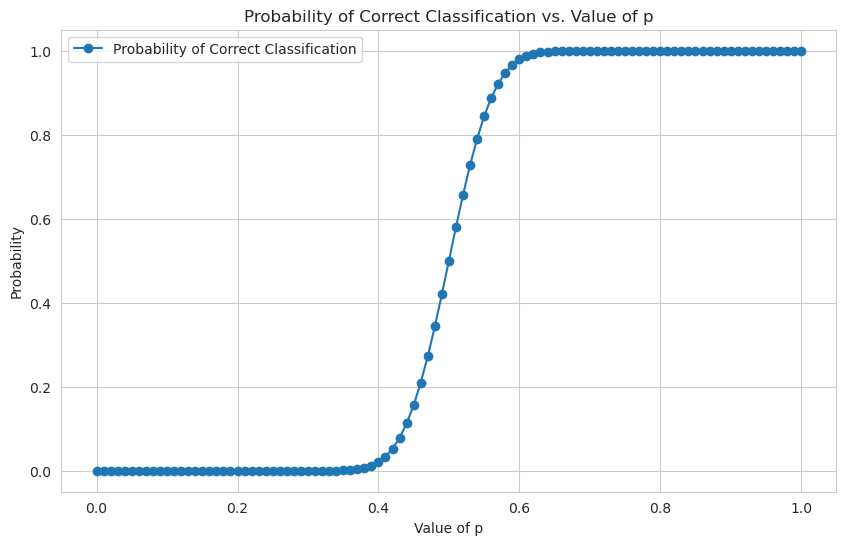

In [36]:
p_values = np.linspace(0, 1, 101)
probabilities = [probability_correct_classification(p) for p in p_values]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(p_values, probabilities,marker='o', linestyle='-', label='Probability of Correct Classification')
plt.xlabel('Value of p')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. Value of p')
plt.grid(True)
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

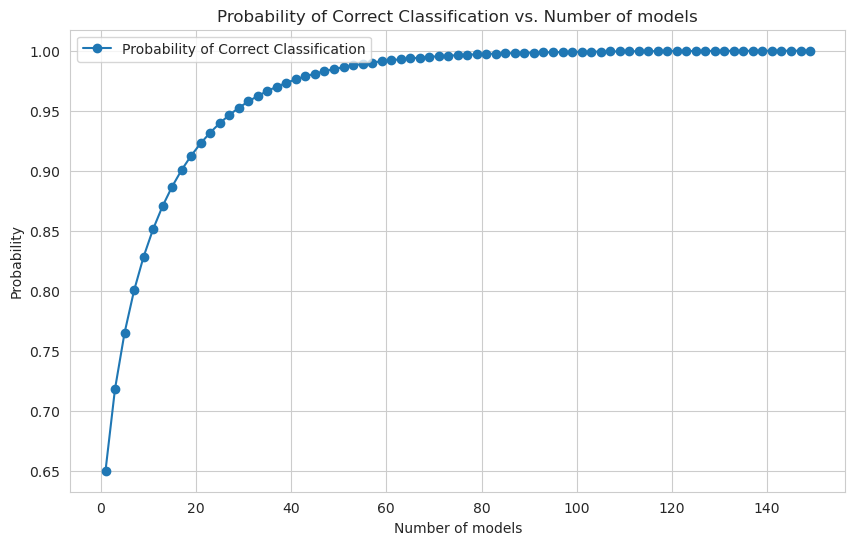

In [39]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

def probability_correct_classification_ensemble(n, p=0.65):
    prob = 0
    for i in range((n + 1) // 2, n + 1):
        prob += math.comb(n, i) * (p ** i) * (1 - p) ** (n - i)
    return prob

models_n = np.arange(1, 150, 2)
probabilities = [probability_correct_classification_ensemble(nm) for nm in models_n]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(models_n, probabilities,marker='o', linestyle='-', label='Probability of Correct Classification')
plt.xlabel('Number of models')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. Number of models')
plt.grid(True)
plt.legend()
plt.show()

Опишите ваши наблюдения:

* при вероятности <0.5 для каждого дерева в ансамбле итоговое пресказание хуже, чем для одной модели с вероятностью 0.65 .
* зависимость вероятности верной классификации от вероятности модели сигмоидная с резким изгибом в районе p = 0.5. Причем при достижении ~0.6 график начинает выходить на плато с точностью предсказаний ансамбля в районе 1. Для хорошей классификации достаточно, чтобы модель в лесу имела вес выше 0.5
* рост вероятности верной классификации от количества моделей имеет сначала экспоненциальную природу, с постепенным насыщением при пороговом количестве моделей, плато достигнуто при 80 моделях для p=0.65

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [48]:
class RandomForestClassifierCustom:
    def __init__(
        self, n_estimators=10, min_samples_leaf=1, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.min_samples_leaf = min_samples_leaf

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        # Получаем уникальные классы
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):
            # Фиксируем генератор случайных чисел
            np.random.seed(self.random_state+i)
            # Выбираем случайные признаки для текущего дерева
            feat_ids = np.random.choice(n_features, min(n_features, self.max_features), replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            
            # Сэмплируем данные с заменой (бутстрэп)
            sample_indices = np.random.randint(0, n_samples, size=n_samples)
            X_sampled = X[sample_indices][:, feat_ids]
            y_sampled = y[sample_indices]
            
            # Обучаем дерево решений
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, 
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X_sampled, y_sampled)
            
            self.trees.append(tree)
            
        return self
    
    def predict_proba(self, X):
        # Инициализируем массив вероятностей
        probas = np.zeros((X.shape[0], len(self.classes_)))
        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            # Предсказываем вероятности для текущего дерева и суммируем их
            probas += tree.predict_proba(X[:, feat_ids])

        # Усредняем вероятности по всем деревьям
        return probas / len(self.trees)
    
    def predict(self, X):
        # Предсказываем классы по наибольшей вероятности
        proba = self.predict_proba(X)
        prediction = np.argmax(proba, axis=1)
        
        return prediction


Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [49]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

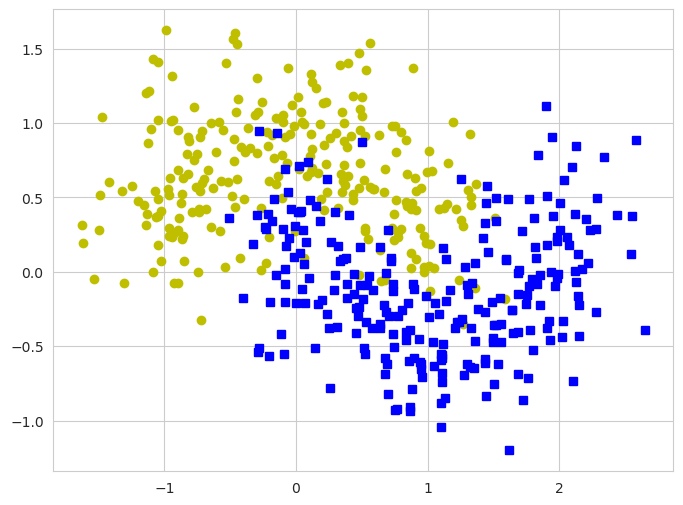

In [50]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [51]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
myforest = RandomForestClassifierCustom(n_estimators=25, max_depth=10, max_features=2)
myforest.fit(X_train, y_train)


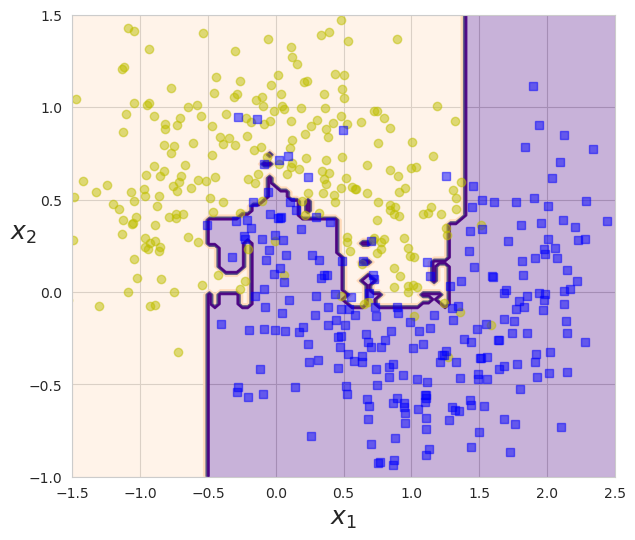

In [52]:
plt.figure(figsize=(7, 6))
plot_decision_boundary(myforest, X, y)

лес заучивает тут шум

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

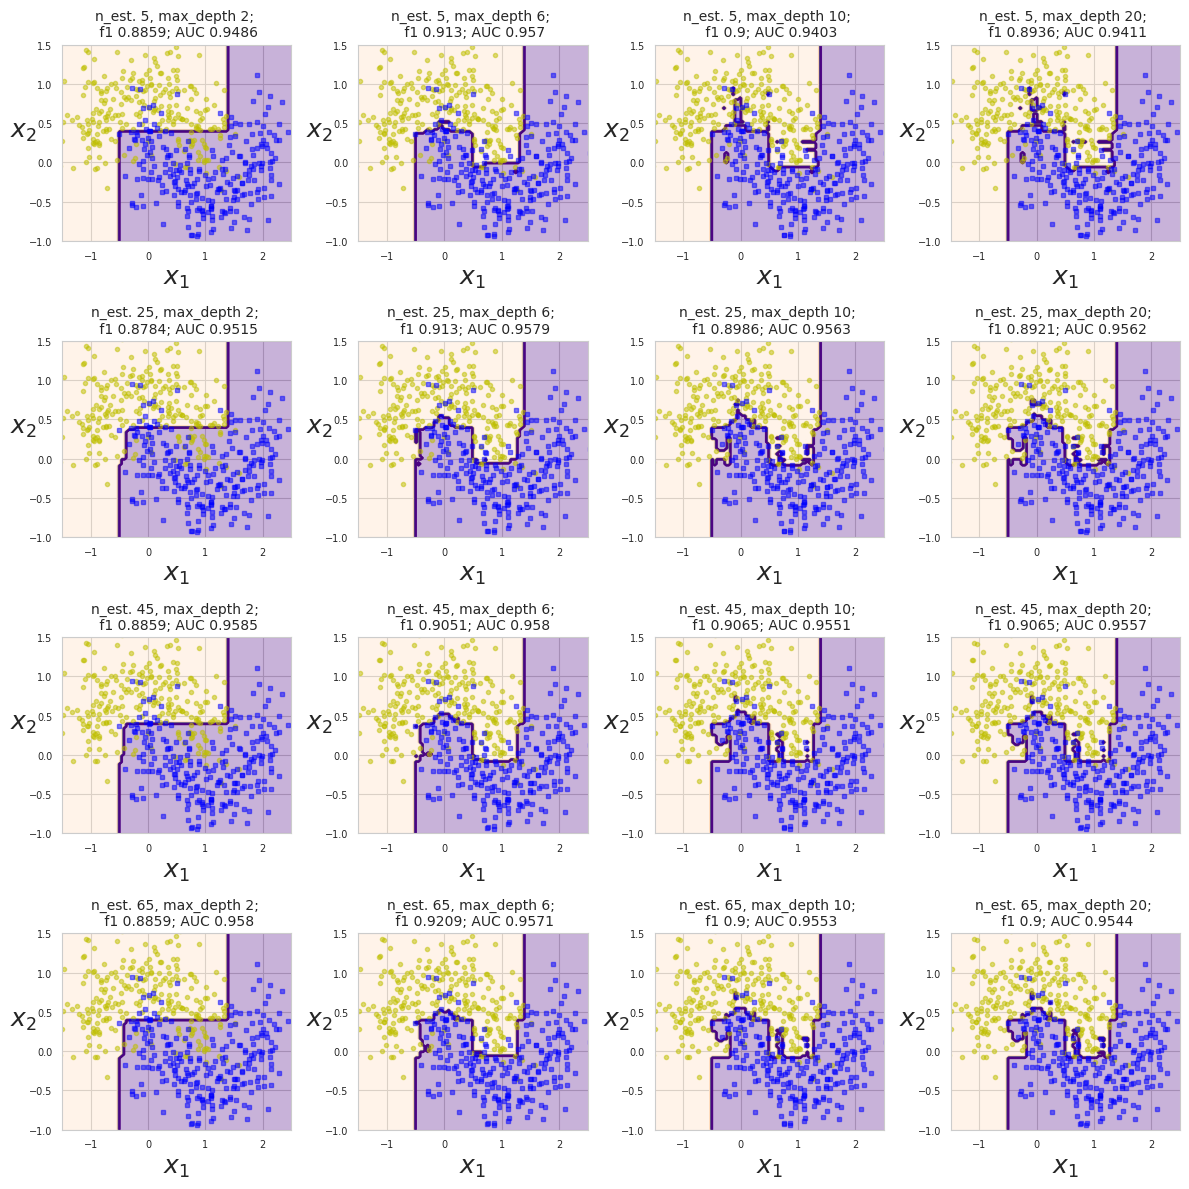

In [58]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

plt.rcParams.update({'lines.markersize': 3})
plt.figure(figsize=(12, 12))

max_depths_list = [2, 6, 10, 20]

for i in range(0, 16):
    n = 5 + 20 * (i // 4)
    max_dp=max_depths_list[i % 4]
    my_tree = RandomForestClassifierCustom(n_estimators=n, max_depth=max_dp, max_features=2)
    my_tree.fit(X_train, y_train)
    y_pred = my_tree.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    y_pred_proba = my_tree.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.subplot(4, 4, i+1)
    plot_decision_boundary(my_tree, X, y)
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.title(f'n_est. {n}, max_depth {max_dp}; \n f1 {f1:.4g}; AUC {auc:.4g}', fontsize=10)

plt.tight_layout()
plt.show();

лучший параметр при визуальной оценке - 65 моделей с глубиной 6, это показывают и метрики f1 и roc_auc

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [59]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [60]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [62]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
model.fit(X_train, y_train)

correlations = base_model_pair_correlation(model, X_test)

print(f'{min(correlations) = }',
      f'{max(correlations) = }',
       f'{np.mean(correlations) = }', sep='\n')

min(correlations) = 0.5863938248013398
max(correlations) = 0.985561360275292
np.mean(correlations) = 0.810935327190054


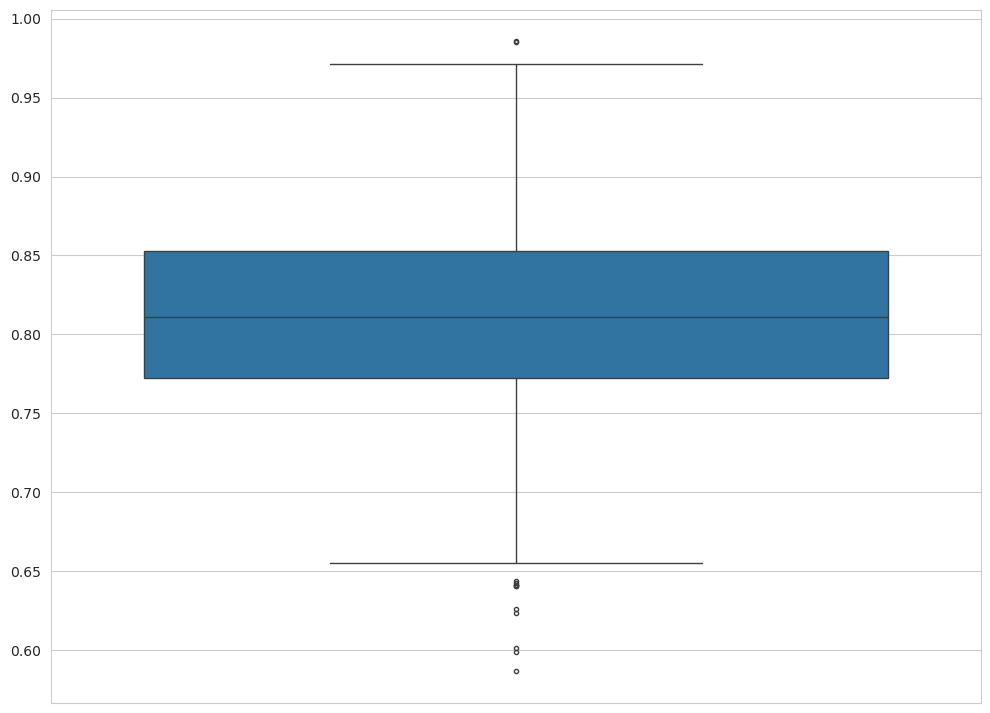

In [63]:
sns.boxplot(data=correlations);

высокая корреляция

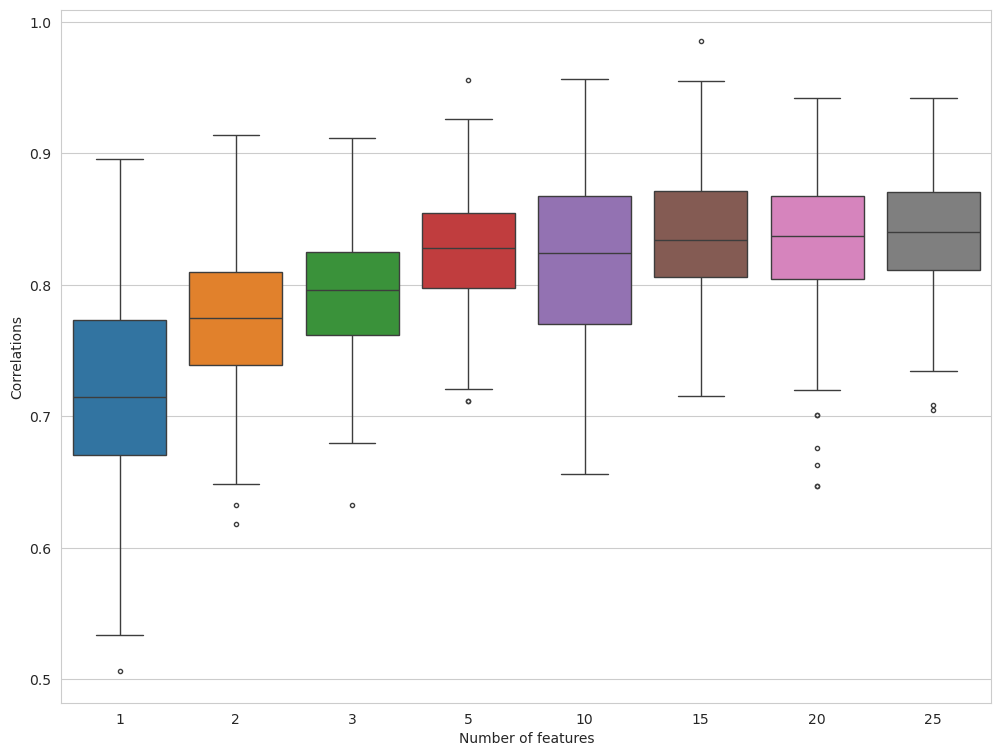

In [66]:
corr_list = []

max_features_list = [1, 2, 3, 5, 10, 15, 20, 25]

for i in max_features_list:
    rf_cl = RandomForestClassifier(n_estimators=20, max_features=i, random_state=SEED)
    rf_cl.fit(X_train, y_train)
    models_corrs = base_model_pair_correlation(rf_cl, X_test)
    corr_list.append(models_corrs)

plt.axes(xlabel = 'Number of features', ylabel = 'Correlations', xticklabels = max_features_list)
sns.boxplot(data=corr_list);    

Больше признаков - выше корреляция, что вцелом логично, однако дисперсия корреляций выше при 10 признаках (ну и 1)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

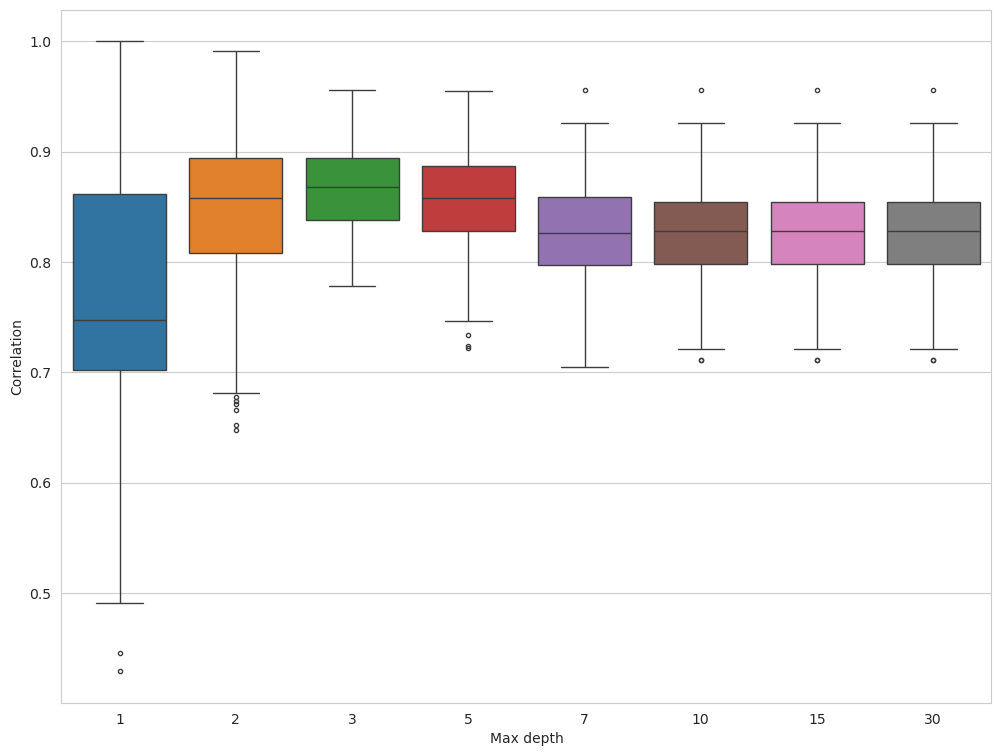

In [67]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
corr_max_depth_list = []

max_depth_list = [1, 2, 3, 5, 7, 10, 15, 30]

for i in max_depth_list:
    rf_cl = RandomForestClassifier(n_estimators=20, max_depth=i, random_state=SEED)
    rf_cl.fit(X_train, y_train)
    models_corrs = base_model_pair_correlation(rf_cl, X_test)
    corr_max_depth_list.append(models_corrs)

plt.axes(xlabel = 'Max depth', ylabel = 'Correlation', xticklabels = max_depth_list)

sns.boxplot(data=corr_max_depth_list);    

с повышением глубины у нас понижается корреляция

Опишите ваши наблюдения:

* Увеличивая количество отбираемых признаком, делаем предсказания более похожими
* Увеличивая глубину, мы увеличиваем переобучаемость отдельных деревьев, следовательно, повышаем разброс предсказаний.
* лучше растить глубину и уменьшать количество отбираемых признаков, чем наоборот

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [71]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O ../data/heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

/home/aryuna/miniconda/envs/mlhws/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [72]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [73]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [75]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
model_scoring = {}

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    if model == voting_hard: # Это необходимо, потому что у voting_hard и soft одинаковые названия классов
        model_scoring['voting_hard'] = scores.mean()
    elif model == voting_soft:
        model_scoring['voting_soft'] = scores.mean()
    else:
        model_scoring[model.__class__.__name__] = scores.mean()

[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [76]:
for key, value in model_scoring.items():
    print(key, 'mean score:', value)

DecisionTreeClassifier mean score: 0.797997226792219
RandomForestClassifier mean score: 0.8328751280279528
CatBoostClassifier mean score: 0.8342715174922052
ExtraTreesClassifier mean score: 0.8281746031746032
KNeighborsClassifier mean score: 0.6493313763861709
SVC mean score: 0.6973119072190279
XGBClassifier mean score: 0.8134522115571786
LGBMClassifier mean score: 0.8132478632478634
XGBRFClassifier mean score: 0.8499478840942256
LogisticRegression mean score: 0.8500073681108163
GaussianNB mean score: 0.8140676625250128
voting_hard mean score: 0.8494440278941667
voting_soft mean score: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [77]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [84]:
def remove_correlated_models(ensemble, X_test, threshold=0.9):
    # Compute correlation between predictions of base models
    corrs = base_model_pair_correlation_for_voting_clf(ensemble, X_test)
    
    # Remove models with correlation above threshold
    models_to_remove = []
    for est1, est2, corr in corrs:
        if corr > threshold:
            models_to_remove.append(est2)
    
    # Remove correlated models from the ensemble
    new_estimators = [est for est in ensemble.estimators_ if est not in models_to_remove]
    ensemble.estimators_ = new_estimators
    
    return ensemble


In [85]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models,
                               voting='hard')

voting_hard.fit(X_train, y_train)

pred_voting_hard = voting_hard.predict(X_test)
corr_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [87]:
voting_hard_without_corr = remove_correlated_models(voting_hard, X_test)
#voting_hard_without_corr = VotingClassifier(estimators=corrected_estimators, voting='hard')
voting_hard_without_corr.fit(X_train, y_train) # новый ансамбль
print('Оценка кросс валидации для нового ансамбля:', cross_val_score(voting_hard_without_corr, X_train, y_train, cv=3, scoring="f1").mean())

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

не поменялось((

In [89]:
def maximize_f1_score(ensemble, X_train, y_train, X_test, y_test):
    best_f1_score = 0
    best_ensemble = ensemble

    for k in range(1, len(ensemble.estimators_) + 1):
        for subset in combinations(ensemble.estimators_, k):
            
            subset_list = [(f"est_{i}", model) for i, model in enumerate(subset)]
            
            # Новый ансамбль
            new_ensemble = VotingClassifier(estimators=subset_list, voting='hard')
            new_ensemble.fit(X_train, y_train)
            y_pred = new_ensemble.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            # обновление ансамбля
            if f1 > best_f1_score:
                best_f1_score = f1
                best_ensemble = new_ensemble

    return best_ensemble, best_f1_score

# Find the ensemble with the maximum F1 score
best_ensemble, max_f1_score = maximize_f1_score(voting_hard, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**